# Latvian Leaflets — Monthly Frequency of a Lemmatized Word (Stanza)

This notebook lets you:
1) Upload a **ZIP** with your leaflet `.txt` files (each file contains metadata and a `text:` block).
2) Choose a **lemma** to track (e.g., `fašisms`).
3) Optionally list **manual variant forms** to force-map to that lemma (safety net for declension forms).
4) Compute **absolute monthly frequencies** of that lemma (no stopword removal; everything is lemmatized).
5) Plot a **monthly frequency chart**.

**Date handling** in metadata (`date:`):
- Exact date: `YYYY-MM-DD` or month `YYYY-MM`.
- Interval: `[YYYY-MM-DD..YYYY-MM-DD]` (also supports Unicode ellipsis `…`). We assign the **midpoint date** to a month.
- Not earlier than: `[YYYY-MM-DD…]` → assigned to the **boundary date** (the given date).
- Not later than: `[…YYYY-MM-DD]` → assigned to the **boundary date** (the given date).
- Unknown `[.]` → **skipped**.

If you prefer a different rule later (e.g., spread counts proportionally across months), we can add it as an option; here we keep it **simple and deterministic**.

In [ ]:
#@title 1) Install and import libraries
!pip -q install stanza==1.6.1 pandas matplotlib tqdm

import os, re, zipfile, io
from collections import Counter, defaultdict
from datetime import datetime, date, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import stanza

try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

print('IN_COLAB:', IN_COLAB)

IN_COLAB: True


In [ ]:
#@title 2) Set your target lemma and manual forms
target_lemma = 'fašisms'  # canonical lemma to count

# all forms mapped to 'fašisms'
manual_forms = [
    'fašisms', 'fašisma', 'fašismam', 'fašismu', 'fašismā',
    'fašismi', 'fašismu', 'fašismiem', 'fašismus', 'fašismos',
    'fašists', 'fašista', 'fašistam', 'fašistu', 'fašistā',
    'fašisti', 'fašistiem', 'fašistus', 'fašistos',
    'fašiste', 'fašistes', 'fašistei', 'fašisti', 'fašistē',
    'fašistes', 'fašistēm', 'fašistēs',
    'fašistisks', 'fašistiska', 'fašistiskam', 'fašistisku', 'fašistiskā',
    'fašistiski', 'fašistiskiem', 'fašistiskus', 'fašistiskos',
    'fašistiskas', 'fašistiskām', 'fašistiskās',
    'fašistiskāks', 'fašistiskāka', 'fašistiskāki', 'fašistiskākas',
    'visfašistiskākais', 'visfašistiskākā', 'visfašistiskākie', 'visfašistiskākās'
]

print('Target lemma:', target_lemma)
print('Manual forms:', manual_forms)

Target lemma: fašisms
Manual forms: ['fašisms', 'fašisma', 'fašismam', 'fašismu', 'fašismā', 'fašismi', 'fašismu', 'fašismiem', 'fašismus', 'fašismos', 'fašists', 'fašista', 'fašistam', 'fašistu', 'fašistā', 'fašisti', 'fašistiem', 'fašistus', 'fašistos', 'fašiste', 'fašistes', 'fašistei', 'fašisti', 'fašistē', 'fašistes', 'fašistēm', 'fašistēs', 'fašistisks', 'fašistiska', 'fašistiskam', 'fašistisku', 'fašistiskā', 'fašistiski', 'fašistiskiem', 'fašistiskus', 'fašistiskos', 'fašistiskas', 'fašistiskām', 'fašistiskās', 'fašistiskāks', 'fašistiskāka', 'fašistiskāki', 'fašistiskākas', 'visfašistiskākais', 'visfašistiskākā', 'visfašistiskākie', 'visfašistiskākās']


In [ ]:
#@title 3) Upload the ZIP with leaflets and extract
leaflet_dir = 'leaflets'  # folder to unpack
if os.path.exists(leaflet_dir):
    # clean up old run
    import shutil
    shutil.rmtree(leaflet_dir)
os.makedirs(leaflet_dir, exist_ok=True)

if IN_COLAB:
    print('Please select your ZIP file with leaflet .txt files...')
    uploaded = files.upload()  # opens a browser dialog in Colab
    if not uploaded:
        raise RuntimeError('No file uploaded.')
    fname = list(uploaded.keys())[0]
    data = uploaded[fname]
else:
    # If running locally, set a path to your ZIP here
    fname = 'leaflets.zip'  # change this to your local path
    with open(fname, 'rb') as f:
        data = f.read()

with zipfile.ZipFile(io.BytesIO(data)) as z:
    z.extractall(leaflet_dir)

# Count .txt files
txt_files = []
for root, _, files_list in os.walk(leaflet_dir):
    for fn in files_list:
        if fn.lower().endswith('.txt'):
            txt_files.append(os.path.join(root, fn))
print(f'Extracted {len(txt_files)} text files.')


Please select your ZIP file with leaflet .txt files...


Saving latvian_communist_leaflets_1934-1940.zip to latvian_communist_leaflets_1934-1940 (1).zip
Extracted 127 text files.


In [ ]:
#@title 4) Download/initialize Stanza for Latvian
stanza.download('lv')
nlp = stanza.Pipeline(lang='lv', processors='tokenize,lemma', tokenize_no_ssplit=True)

INFO:stanza:Downloading default packages for language: lv (Latvian) ...
INFO:stanza:File exists: /root/stanza_resources/lv/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: lv (Latvian):
| Processor | Package       |
-----------------------------
| tokenize  | lvtb          |
| lemma     | lvtb_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [ ]:
#@title 5) Helpers: parse metadata & dates, lemmatize and count
import re
from datetime import datetime, date, timedelta

# Regex helpers to extract fields from a leaflet file
DATE_LINE_RE = re.compile(r'^\s*date\s*:\s*(.+)$', flags=re.IGNORECASE | re.MULTILINE)
PRINT_RUN_RE = re.compile(r'^\s*print_run\s*:\s*(.+)$', flags=re.IGNORECASE | re.MULTILINE)
TEXT_MARK_RE = re.compile(r'^\s*text\s*:\s*$', flags=re.IGNORECASE | re.MULTILINE)
TEXT_INLINE_RE = re.compile(r'^\s*text\s*:\s*(.+)$', flags=re.IGNORECASE | re.MULTILINE | re.DOTALL)

def extract_date_str(content: str):
    """Return the raw value of the `date:` line, or None if not found."""
    m = DATE_LINE_RE.search(content)
    return m.group(1).strip() if m else None

def extract_print_run(content: str):
    """
    Return the print run as an int if it can be parsed, else None.

    Accepted inputs:
      - Plain digits:      '5000'
      - With separators:   '5,000' (non-digits are stripped)
      - Unknown marker:    'unk'  -> returns None
    """
    m = PRINT_RUN_RE.search(content)
    if not m:
        return None
    raw = m.group(1).strip().lower()
    if raw == 'unk':
        return None
    digits = re.sub(r'[^0-9]', '', raw)
    try:
        return int(digits) if digits else None
    except Exception:
        return None

def extract_text_body(content: str):
    """
    Return the leaflet text body.

    Two supported formats:
      1) `text:` on its own line -> everything after that line is the body.
      2) `text: <inline>` on the same line -> the inline part is the body.
    """
    m = TEXT_MARK_RE.search(content)
    if m:
        return content[m.end():].strip()
    m2 = TEXT_INLINE_RE.search(content)
    if m2:
        return m2.group(1).strip()
    return ''

def parse_bracketed_date(date_str: str):
    """
    Parse bracketed/approximate date formats and return a `datetime.date` or None.

    Supported forms and rules:
      - [YYYY-MM-DD..YYYY-MM-DD]  → midpoint of the interval
      - [YYYY-MM-DD…]             → "not earlier than" → use the given boundary date
      - […YYYY-MM-DD]             → "not later than"   → use the given boundary date
      - [YYYY-MM-DD]              → exact date
      - [YYYY-MM]                 → last day of that month
      - [.]                       → unreadable/unknown → return None

    Note: Unicode ellipsis (…) is normalized to '..' for parsing.
    """
    s = date_str.strip()
    if s == '[.]':
        return None
    s_norm = s.replace('…', '..')
    inner = s_norm[1:-1].strip() if s_norm.startswith('[') and s_norm.endswith(']') else s_norm

    # [start..end]
    if '..' in inner and not inner.startswith('..') and not inner.endswith('..'):
        start_str, end_str = [x.strip() for x in inner.split('..', 1)]
        try:
            start = datetime.strptime(start_str, '%Y-%m-%d').date()
            end = datetime.strptime(end_str, '%Y-%m-%d').date()
            mid = start + (end - start) / 2
            return date.fromtimestamp(mid.timestamp())
        except Exception:
            return None

    # [start..]
    if inner.endswith('..') and not inner.startswith('..'):
        start_str = inner[:-2].strip()
        for fmt in ('%Y-%m-%d', '%Y-%m'):
            try:
                dt = datetime.strptime(start_str, fmt)
                if fmt == '%Y-%m':
                    return date(dt.year, dt.month, 1)
                return dt.date()
            except Exception:
                pass
        return None

    # [..end]
    if inner.startswith('..') and not inner.endswith('..'):
        end_str = inner[2:].strip()
        for fmt in ('%Y-%m-%d', '%Y-%m'):
            try:
                dt = datetime.strptime(end_str, fmt)
                if fmt == '%Y-%m':
                    year, month = dt.year, dt.month
                    if month == 12:
                        return date(year, 12, 31)
                    next_month = date(year, month + 1, 1)
                    return next_month - timedelta(days=1)
                return dt.date()
            except Exception:
                pass
        return None

    # Exact date or month
    for fmt in ('%Y-%m-%d', '%Y-%m'):
        try:
            dt = datetime.strptime(inner, fmt)
            if fmt == '%Y-%m':
                year, month = dt.year, dt.month
                if month == 12:
                    return date(year, 12, 31)
                next_month = date(year, month + 1, 1)
                return next_month - timedelta(days=1)
            return dt.date()
        except Exception:
            pass
    return None

def parse_any_date(date_str: str):
    """Parse either exact or bracketed date strings. Return `date` or None."""
    if not date_str:
        return None
    s = date_str.strip()
    if s.startswith('['):
        return parse_bracketed_date(s)
    for fmt in ('%Y-%m-%d', '%Y-%m'):
        try:
            dt = datetime.strptime(s, fmt)
            if fmt == '%Y-%m':
                year, month = dt.year, dt.month
                if month == 12:
                    return date(year, 12, 31)
                next_month = date(year, month + 1, 1)
                return next_month - timedelta(days=1)
            return dt.date()
        except Exception:
            pass
    return None

# Manual mapping and target lemma (both compared case-insensitively)
manual_set = set(x.lower() for x in manual_forms)
target_lower = target_lemma.lower()

def count_target_and_tokens(txt: str):
    """
    Tokenize + lemmatize with Stanza and return a tuple:
      (count_target_lemma, total_tokens)

    Details:
      - No stopword removal: every token is counted in `total_tokens`.
      - Manual mapping (`manual_forms`) is applied *before* comparing to the target:
        if a token's lowercased text is in `manual_forms`, it is forced to `target_lemma`.
      - Comparison is case-insensitive for both token text and lemma.
    """
    doc = nlp(txt)
    cnt_target = 0
    cnt_tokens = 0
    for sent in doc.sentences:
        for w in sent.words:
            cnt_tokens += 1
            token_lower = (w.text or '').lower()
            if token_lower in manual_set:
                lemma = target_lower
            else:
                lemma = (w.lemma or w.text or '').lower()
            if lemma == target_lower:
                cnt_target += 1
    return cnt_target, cnt_tokens

In [ ]:
#@title 5A) Compute DEFAULT_WEIGHT_FOR_UNK (median of known print_run)
from statistics import median

known_print_runs = []

for path in sorted(txt_files):
    # read the file (same approach as in the processing cell, with encoding fallbacks)
    try:
        with open(path, 'r', encoding='utf-8', errors='replace') as f:
            content = f.read()
    except Exception:
        with open(path, 'r', encoding='latin-1', errors='replace') as f:
            content = f.read()

    pr = extract_print_run(content)  # int or None
    if pr is not None:
        known_print_runs.append(pr)

if known_print_runs:
    DEFAULT_WEIGHT_FOR_UNK = int(median(known_print_runs))
else:
    DEFAULT_WEIGHT_FOR_UNK = 500  # fallback if there are no known print runs at all

print(f"DEFAULT_WEIGHT_FOR_UNK = {DEFAULT_WEIGHT_FOR_UNK}  (based on {len(known_print_runs)} known print_run values)")

DEFAULT_WEIGHT_FOR_UNK = 3000  (based on 95 known print_run values)


In [ ]:
#@title Share of unknown files
import numpy as np

q1, q2, q3 = np.quantile(known_print_runs, [0.25, 0.5, 0.75])
print("Q1, median, Q3:", q1, q2, q3)
share_unk = 1 - len(known_print_runs)/len(txt_files)
print(f"Share of UNK files: {share_unk:.1%}")

Q1, median, Q3: 1000.0 3000.0 4000.0
Share of UNK files: 25.2%


In [ ]:
#@title Optional override for unknown print_run
DEFAULT_WEIGHT_FOR_UNK = 500   # ← поставь 500/1000/3000 по своему сценарию
print("Override DEFAULT_WEIGHT_FOR_UNK =", DEFAULT_WEIGHT_FOR_UNK)

Override DEFAULT_WEIGHT_FOR_UNK = 500


In [ ]:
#@title 6) Process all files → monthly counts & tokens (weighted/unweighted)
from collections import Counter
from tqdm import tqdm
import os

# aggregators
m_raw_lemma = Counter()      # sum of lemma occurrences (unweighted)
m_raw_tokens = Counter()     # sum of tokens (unweighted)
m_w_lemma = Counter()        # sum of lemma occurrences * weight
m_w_tokens = Counter()       # sum of tokens * weight

skipped_no_date = 0
unknown_print_run_files = 0

files_with_stats = []  # (file_name, month, raw_lemma, raw_tokens, print_run, w_lemma, w_tokens)

for path in tqdm(sorted(txt_files)):
    # read file (with encoding fallbacks)
    try:
        with open(path, 'r', encoding='utf-8', errors='replace') as f:
            content = f.read()
    except Exception:
        with open(path, 'r', encoding='latin-1', errors='replace') as f:
            content = f.read()

    # date → month
    dstr = extract_date_str(content)
    d = parse_any_date(dstr) if dstr else None
    if not d:
        skipped_no_date += 1
        continue
    month_key = f"{d.year:04d}-{d.month:02d}"

    # text → (lemma occurrences, tokens)
    body = extract_text_body(content)
    raw_lemma, raw_tokens = count_target_and_tokens(body)

    # print run → weight (unk -> DEFAULT_WEIGHT_FOR_UNK)
    pr = extract_print_run(content)
    if pr is None:
        unknown_print_run_files += 1
        weight = DEFAULT_WEIGHT_FOR_UNK
    else:
        weight = pr

    # weighted values
    w_lemma = raw_lemma * weight
    w_tokens = raw_tokens * weight

    # aggregate by month
    m_raw_lemma[month_key] += raw_lemma
    m_raw_tokens[month_key] += raw_tokens
    m_w_lemma[month_key] += w_lemma
    m_w_tokens[month_key] += w_tokens

    files_with_stats.append((os.path.basename(path), month_key, raw_lemma, raw_tokens, pr, w_lemma, w_tokens))

print('Files with no determinable date skipped:', skipped_no_date)
print('Files with unknown print_run (treated as weight=500):', unknown_print_run_files)
len(files_with_stats)

100%|██████████| 127/127 [01:03<00:00,  2.00it/s]

Files with no determinable date skipped: 6
Files with unknown print_run (treated as weight=500): 30


121

In [ ]:
#@title 7) Build monthly DataFrame with relative frequencies (per 1000 tokens)
import pandas as pd

def build_month_range(keys):
    if not keys:
        return []
    months_sorted = sorted(keys)
    sy, sm = map(int, months_sorted[0].split('-'))
    ey, em = map(int, months_sorted[-1].split('-'))
    y, m = sy, sm
    out = []
    while True:
        out.append(f"{y:04d}-{m:02d}")
        if y == ey and m == em:
            break
        m += 1
        if m == 13:
            y += 1
            m = 1
    return out

all_months = set(m_raw_lemma) | set(m_raw_tokens) | set(m_w_lemma) | set(m_w_tokens)
ym_list = build_month_range(all_months) if all_months else []

def safe_rel_per_1000(numer, denom):
    return (numer / denom * 1000.0) if denom > 0 else 0.0

data = pd.DataFrame({
    'month': ym_list,
    'abs_lemma_unweighted': [m_raw_lemma.get(ym, 0) for ym in ym_list],
    'abs_tokens_unweighted': [m_raw_tokens.get(ym, 0) for ym in ym_list],
    'abs_lemma_weighted':   [m_w_lemma.get(ym, 0) for ym in ym_list],
    'abs_tokens_weighted':  [m_w_tokens.get(ym, 0) for ym in ym_list],
})

# относительные частоты на 1000 токенов
data['rel_per_1000_unweighted'] = [
    safe_rel_per_1000(m_raw_lemma.get(ym, 0), m_raw_tokens.get(ym, 0)) for ym in ym_list
]
data['rel_per_1000_weighted'] = [
    safe_rel_per_1000(m_w_lemma.get(ym, 0), m_w_tokens.get(ym, 0)) for ym in ym_list
]

data.head(), data.tail()

(     month  abs_lemma_unweighted  abs_tokens_unweighted  abs_lemma_weighted  \
 0  1934-01                    46                   5685               71500   
 1  1934-02                    31                   7719              157500   
 2  1934-03                    36                   5150               66500   
 3  1934-04                    58                   6042              255900   
 4  1934-05                    61                   4118              115000   
 
    abs_tokens_weighted  rel_per_1000_unweighted  rel_per_1000_weighted  
 0             14798000                 8.091469               4.831734  
 1             30227500                 4.016064               5.210487  
 2             12904000                 6.990291               5.153441  
 3             31101200                 9.599470               8.227978  
 4              8139500                14.813016              14.128632  ,
       month  abs_lemma_unweighted  abs_tokens_unweighted  abs_lemma_weig

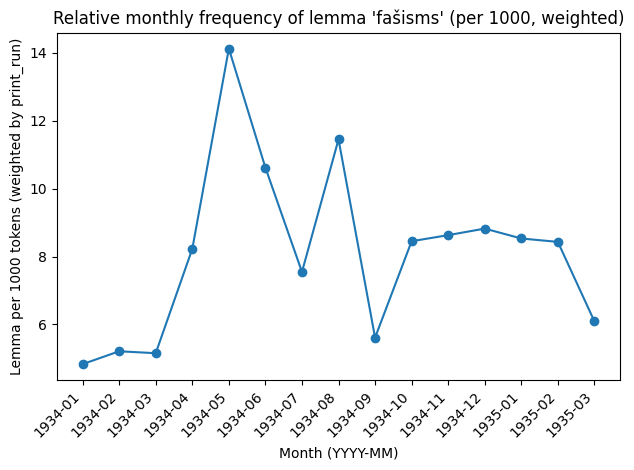

In [ ]:
#@title 8) Plot RELATIVE monthly frequency (per 1000 tokens) — weighted
import matplotlib.pyplot as plt

plt.figure()
plt.plot(data['month'], data['rel_per_1000_weighted'], marker='o')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Month (YYYY-MM)')
plt.ylabel('Lemma per 1000 tokens (weighted by print_run)')
plt.title(f"Relative monthly frequency of lemma '{target_lemma}' (per 1000, weighted)")
plt.tight_layout()
plt.show()

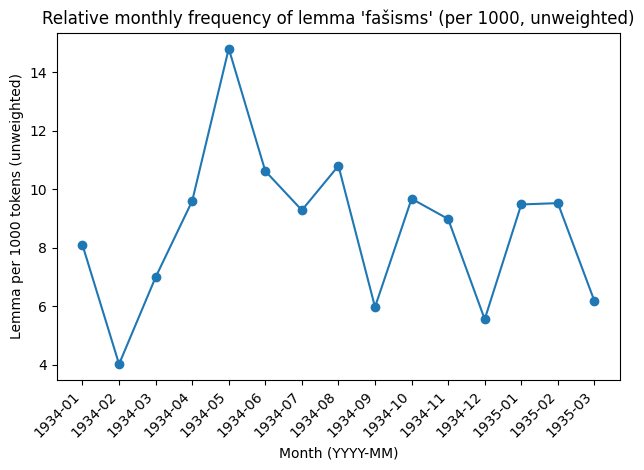

In [ ]:
#@title 9) Plot RELATIVE monthly frequency — unweighted
import matplotlib.pyplot as plt

plt.figure()
plt.plot(data['month'], data['rel_per_1000_unweighted'], marker='o')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Month (YYYY-MM)')
plt.ylabel('Lemma per 1000 tokens (unweighted)')
plt.title(f"Relative monthly frequency of lemma '{target_lemma}' (per 1000, unweighted)")
plt.tight_layout()
plt.show()

### Notes (relative frequency version)

- **What is shown here**
  - `rel_per_1000_unweighted` = (sum of lemma hits) / (sum of tokens) × 1000 per calendar month.
  - `rel_per_1000_weighted`   = (∑ hits × print_run) / (∑ tokens × print_run) × 1000 per month.
  - This normalizes for total text volume; the weighted series also reflects likely audience reach via print runs.

- **Lemmatization & counting**
  - Language: Latvian via **Stanza** (version pinned in the install cell).
  - No stopword removal: **every Stanza token in `sent.words` counts** toward the denominator.
  - Manual mapping (the `manual_forms` list) is **case-insensitive** and applied **before** comparing to the target lemma (use it to force variants/adjectives to the same lemma).

- **Print runs**
  - Weight = `print_run` when available; for unknown values we use `DEFAULT_WEIGHT_FOR_UNK`.
  - `DEFAULT_WEIGHT_FOR_UNK` is computed in cell **5A** (median of known print runs), or can be overridden (e.g., 500 / 1000) with a small override cell.

- **Dates**
  - Exact `YYYY-MM-DD` goes to that month; `YYYY-MM` uses the **last day of month** to bucket.
  - Intervals `[start..end]` use the **midpoint**; `[start…]` (“not earlier than”) and `[…end]` (“not later than”) use the **boundary date**.
  - `[.]` (unreadable) is skipped.
  - Results are aggregated by **calendar month** (no normalization by month length).

- **Caveats**
  - Interval midpointing can shift counts between adjacent months.
  - Unknown print runs may be a sizable share; the weighted series is therefore **sensitive** to your chosen default—consider a short sensitivity check (e.g., 500 vs 1000 vs median).
  - Token counts include punctuation as provided by Stanza `sent.words`. If you prefer to **exclude punctuation/numbers**, filter by UPOS (e.g., keep only `NOUN, VERB, ADJ, ADV, PROPN`).

- **Easy tweaks**
  - Change the normalization scale (per 1, per 10k, per 1M) by adjusting the multiplier.
  - Swap the interval strategy (e.g., distribute counts by days across months) if needed.
  - Plot multiple lemmas together by repeating the aggregation for each target and joining by `month`.